In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image
print(os.listdir("input"))
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, AUC
import seaborn as sns
import shap
from tensorflow.keras.applications.vgg19 import preprocess_input,VGG19
from datetime import datetime
start_time = datetime.now()

tf.random.set_seed(11)
np.random.seed(11)
import random
random.seed(11)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

['chest_xray']


In [2]:
#defining folder parameters #print(mainDIR)
mainDIR = os.listdir('input/chest_xray/chest_xray')
train_folder= 'input/chest_xray/chest_xray/train/'
val_folder = 'input/chest_xray/chest_xray/val/'
test_folder = 'input/chest_xray/chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'
val_n = val_folder+'NORMAL/'
val_p = val_folder+'PNEUMONIA/'
test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

print("nbr of normal pictures in trainingset: " + str(len(os.listdir(train_n))))
print("nbr of sick pictures in trainingset: " + str(len(os.listdir(train_p))))
print("nbr of normal pictures in testset: " + str(len(os.listdir(test_n))))
print("nbr of sick pictures in testset: " + str(len(os.listdir(test_p))))
print("nbr of normal pictures in validationset: " + str(len(os.listdir(val_n))))
print("nbr of sick pictures in validationset: " + str(len(os.listdir(val_p))))

nbr of normal pictures in trainingset: 1342
nbr of sick pictures in trainingset: 3876
nbr of normal pictures in testset: 234
nbr of sick pictures in testset: 390
nbr of normal pictures in validationset: 9
nbr of sick pictures in validationset: 9


In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 1,
                                   zoom_range = 0.2,
                                   horizontal_flip = False,
                                   preprocessing_function=preprocess_input) 

rescaled_set = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input) 


In [4]:
training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 color_mode='rgb',
                                                 seed = 11,
                                                 shuffle=True,
                                                 class_mode = 'binary')

validation_generator = rescaled_set.flow_from_directory(val_folder,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                color_mode='rgb',
                                                class_mode='binary')

test_set = rescaled_set.flow_from_directory(test_folder,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            color_mode='rgb',
                                            class_mode = 'binary',
                                            shuffle=False) 

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
print(validation_generator.class_indices)
print(training_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
model = VGG19(include_top = False,weights = 'imagenet',input_shape= (224,224,3))

# Freeze the imported layers so they cannot be retrained.
for layer in model.layers:
    layer.trainable = False    

model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
#new_model.add(Dropout(0.2))
new_model.add(Dense(activation = 'sigmoid', units = 1))
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
new_model.compile(optimizer= 'adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])
# history = new_model.fit(training_set, epochs=1, batch_size=32, validation_data=validation_generator)

In [9]:
# Define early stopping    
early_stop = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving
    patience=2,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)
# Train the model with early stopping
history = new_model.fit(
    training_set,
    epochs=10,  # Set a high number, but training will stop early if needed
    validation_data=validation_generator,
    callbacks=[early_stop]  # Attach early stopping
)

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 592s 4s/step - accuracy: 0.8398 - auc: 0.8682 - loss: 0.3981 - precision: 0.8886 - recall: 0.8904 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2918 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.9517 - auc: 0.9874 - loss: 0.1275 - precision: 0.9685 - recall: 0.9669 - val_accuracy: 0.7500 - val_auc: 0.9688 - val_loss: 0.4766 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 612s 4s/step - accuracy: 0.9623 - auc: 0.9917 - loss: 0.0994 - precision: 0.9727 - recall: 0.9769 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2016 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.9651 - auc: 0.9928 - loss: 0.0946 - precision: 0.9770 - recall: 0.9759 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2584 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━

In [10]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


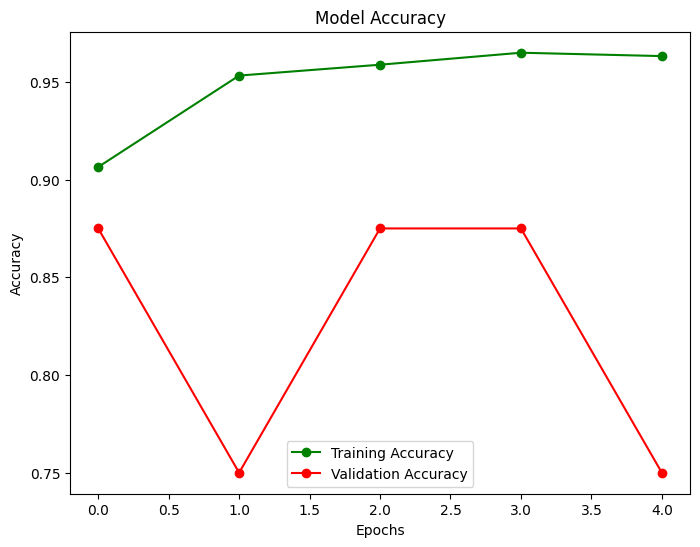

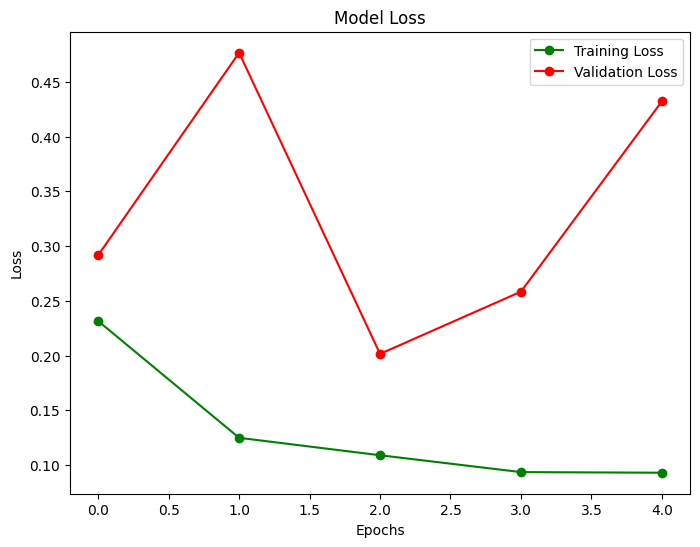

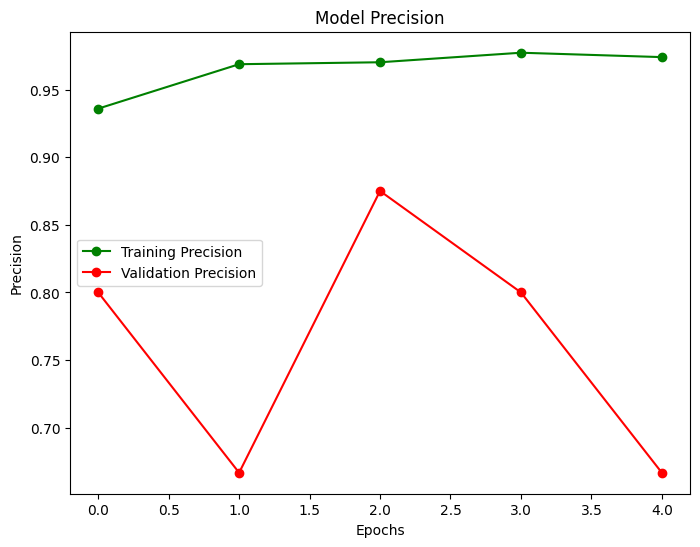

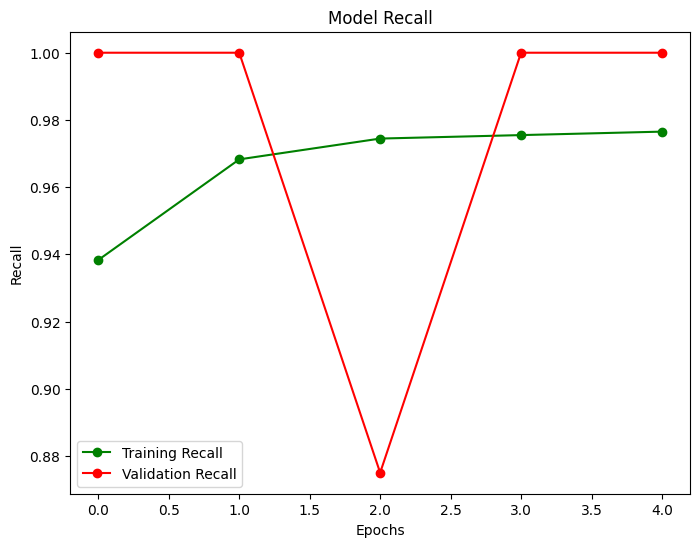

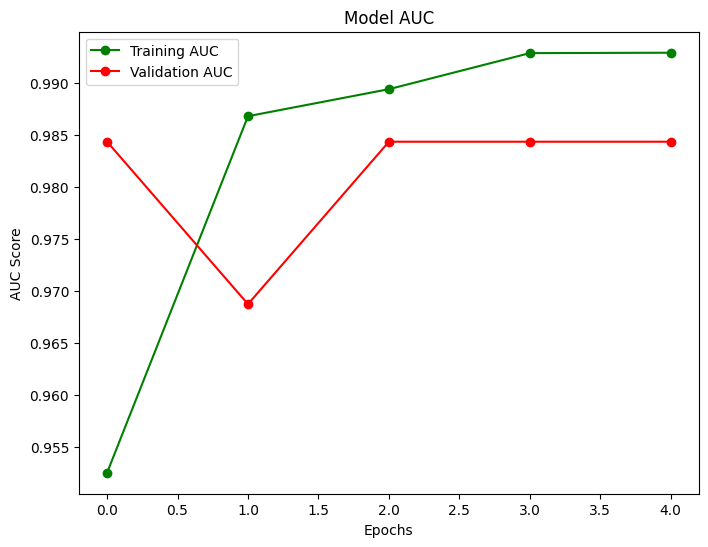

In [11]:
# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], 'go-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'go-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot Precision
plt.figure(figsize=(8,6))
plt.plot(history.history['precision'], 'go-', label='Training Precision')
plt.plot(history.history['val_precision'], 'ro-', label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()
# Plot Recall
plt.figure(figsize=(8,6))
plt.plot(history.history['recall'], 'go-', label='Training Recall')
plt.plot(history.history['val_recall'], 'ro-', label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()
# Plot AUC
plt.figure(figsize=(8,6))
plt.plot(history.history['auc'], 'go-', label='Training AUC')
plt.plot(history.history['val_auc'], 'ro-', label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()


In [12]:
loss, accuracy, precision, recall, auc = new_model.evaluate(test_set)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC: {auc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9069 - auc: 0.6416 - loss: 0.2802 - precision: 0.5464 - recall: 0.6305
Test Loss: 0.23
Test Accuracy: 0.92
Precision: 0.93
Recall: 0.95
AUC: 0.96


20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step
Confusion Matrix:
 [[204  30]
 [ 18 372]]


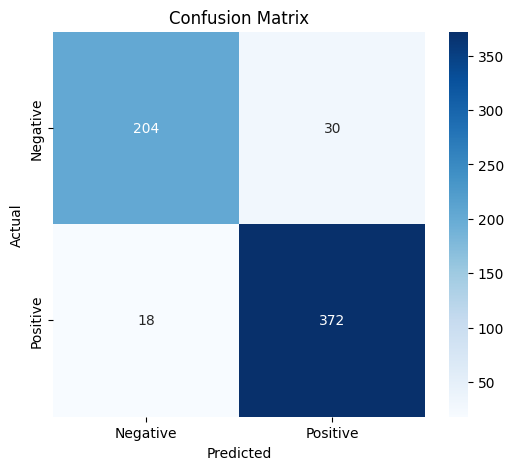

In [13]:
# Compute confusion matrix
y_true = test_set.classes
# Compute confusion matrix using evaluate()
y_pred_eval = (new_model.predict(test_set) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true, y_pred_eval)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
print(classification_report(y_true, y_pred_eval, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.92      0.87      0.89       234
    Positive       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



random normal picture :  NORMAL2-IM-0384-0001.jpeg
random sick picture : person1308_bacteria_3286.jpeg
Normal Image Size: (1268, 924)
Pneumonia Image Size: (1480, 856)
Image Mode normal image: L
Image Mode sick image: L


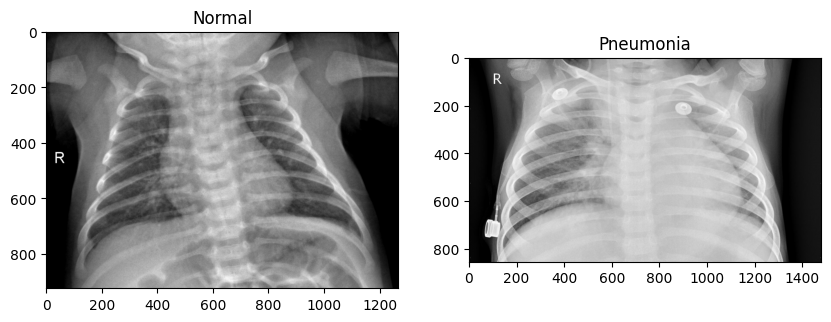

In [15]:
# analysing random training data #
# Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('random normal picture : ',norm_pic)
norm_pic_address = train_n+norm_pic
norm_load = Image.open(norm_pic_address)
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')
#Pneumonia 
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('random sick picture :', sic_pic)
sic_load = Image.open(sic_address)
a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia');
# Size
print("Normal Image Size:", norm_load.size)  # Output (width, height)
print("Pneumonia Image Size:", sic_load.size)
# Get mode (color format) # L is one channel
print("Image Mode normal image:", norm_load.mode) 
print("Image Mode sick image:", sic_load.mode)

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01560135930776596..0.014151424169540405].


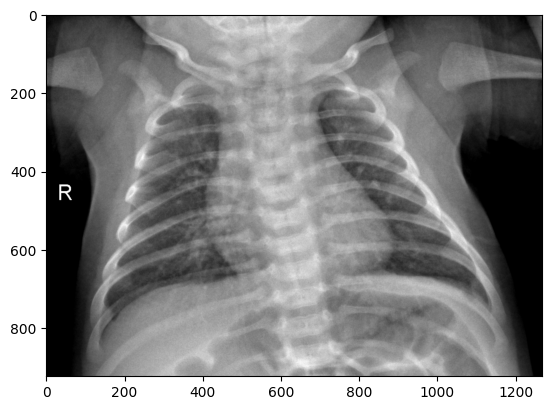

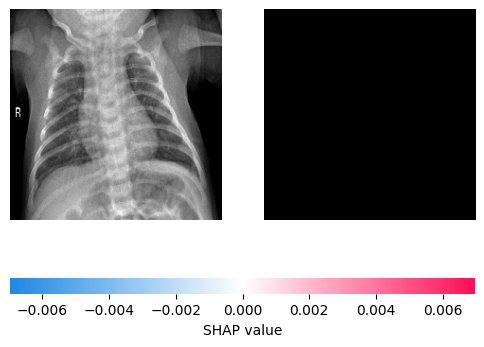

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Prediction Probability: 0.05
Predicted Class: Normal


In [16]:
image_path = norm_pic_address
load = Image.open(image_path)
img_plot = plt.imshow(load, cmap='gray') # Display the original image
img = load_img(image_path, target_size=(224, 224), color_mode="rgb")  # Resize to match model input
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
background = np.random.randn(1, 224, 224, 3)  # Create background data (required for GradientExplainer)
explainer = shap.GradientExplainer(new_model, background) # Use SHAP GradientExplainer
shap_values = explainer.shap_values(img_array) # Get SHAP values for the image
shap.image_plot(shap_values, img_array) # Visualize SHAP explanations
prediction = new_model.predict(img_array)[0][0]
predicted_class = "Pneumonia" if prediction > 0.5 else "Normal" 
print(f"Prediction Probability: {prediction:.2f}")
print(f"Predicted Class: {predicted_class}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006755077745765448..0.0073737758211791515].


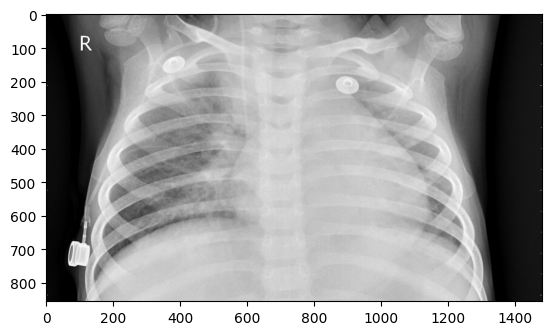

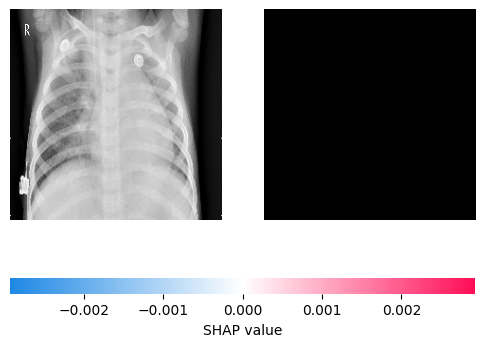

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Prediction Probability: 0.63
Predicted Class: Pneumonia


In [17]:
image_path = sic_address
load = Image.open(image_path)
img_plot = plt.imshow(load, cmap='gray') # Display the original image
img = load_img(image_path, target_size=(224, 224), color_mode="rgb")  # Resize to match model input
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
background = np.random.randn(10, 224, 224, 3)  # Create background data (required for GradientExplainer)
explainer = shap.GradientExplainer(new_model, background) # Use SHAP GradientExplainer
shap_values = explainer.shap_values(img_array) # Get SHAP values for the image
shap_values = np.clip(shap_values, -1, 1)
shap.image_plot(shap_values, img_array) # Visualize SHAP explanations
prediction = new_model.predict(img_array)[0][0]
predicted_class = "Pneumonia" if prediction > 0.5 else "Normal" 
print(f"Prediction Probability: {prediction:.2f}")
print(f"Predicted Class: {predicted_class}")

In [18]:
end_time = datetime.now()
duration = end_time - start_time
full_minutes = duration.seconds // 60  # Full minutes
remaining_seconds = duration.seconds % 60  # Remainder in seconds
print(f"Duration: {full_minutes} minutes and {remaining_seconds} seconds")

Duration: 54 minutes and 32 seconds
